In [1]:
%matplotlib inline

In [2]:
import random

from collections.abc import Callable
from datetime import UTC, datetime
from pathlib import Path

In [65]:
import matplotlib.pyplot as plot
import numpy
import torch

from rich import print as pprint
from rich.progress import Progress
from rich.rule import Rule
from torch import Tensor
from torch.nn import L1Loss, Module, MSELoss
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader

In [4]:
from baikal.common.dataset.arrow import memory_map_dataset
from baikal.ml.torch.dataset import (
    ArrowTimeSeriesBatch,
    ArrowTimeSeriesDataset,
    StrideWindowStrategy,
)
from baikal.ml.torch.models import NLinearIndividual, NLinearUnified

In [5]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)

pprint(device)

cpu

In [6]:
random.seed(0xDEADBEEF)

torch.manual_seed(0xDEADBEEF)
numpy.random.seed(0xDEADBEEF)

## Experiment Variables

In [7]:
DATASET_NAME = "indicators/binance/spot/BTCUSDT"

In [8]:
TRAIN_DATASET_START = datetime(2018, 1, 1, tzinfo=UTC)
TRAIN_DATASET_END = datetime(2025, 1, 1, tzinfo=UTC)

In [9]:
VALIDATION_DATASET_START = datetime(2025, 1, 1, tzinfo=UTC)
VALIDATION_DATASET_END = datetime(2025, 5, 1, tzinfo=UTC)

In [10]:
TEST_DATASET_START = datetime(2025, 5, 1, tzinfo=UTC)
TEST_DATASET_END = datetime(2025, 9, 1, tzinfo=UTC)

In [11]:
EPOCHS = 10
BATCH_SIZE = 256

FEATURE_WINDOW = 300
TARGET_WINDOW = 30
WINDOW_STRIDE = 30

In [12]:
dataset = memory_map_dataset(Path("../data/processed") / DATASET_NAME).to_table()

In [89]:
feature_columns = ["open", "high", "low", "close", "volume"]
target_columns = ["open", "high", "low", "close", "volume"]

open_index = target_columns.index("open")
high_index = target_columns.index("high")
low_index = target_columns.index("low")
close_index = target_columns.index("close")
volume_index = target_columns.index("volume")

## Setup

In [14]:
train_windows = StrideWindowStrategy(
    dataset,
    "date_time",
    frequency="1m",
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    stride=WINDOW_STRIDE,
    start=TRAIN_DATASET_START,
    end=TRAIN_DATASET_END,
)

train_dataset = ArrowTimeSeriesDataset(
    dataset,
    train_windows,
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    features=feature_columns,
    targets=target_columns,
)

pprint("Train dataset length: ", len(train_dataset))

Train dataset length:  120575

In [15]:
validation_windows = StrideWindowStrategy(
    dataset,
    "date_time",
    frequency="1m",
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    stride=WINDOW_STRIDE,
    start=VALIDATION_DATASET_START,
    end=VALIDATION_DATASET_END,
)

validation_dataset = ArrowTimeSeriesDataset(
    dataset,
    validation_windows,
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    features=feature_columns,
    targets=target_columns,
)

pprint("Validation dataset length: ", len(validation_dataset))

Validation dataset length:  5750

In [16]:
test_windows = StrideWindowStrategy(
    dataset,
    "date_time",
    frequency="1m",
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    stride=WINDOW_STRIDE,
    start=TEST_DATASET_START,
    end=TEST_DATASET_END,
)

test_dataset = ArrowTimeSeriesDataset(
    dataset,
    test_windows,
    feature_window=FEATURE_WINDOW,
    target_window=TARGET_WINDOW,
    features=feature_columns,
    targets=target_columns,
)

pprint("Test dataset length: ", len(test_dataset))

Test dataset length:  5894

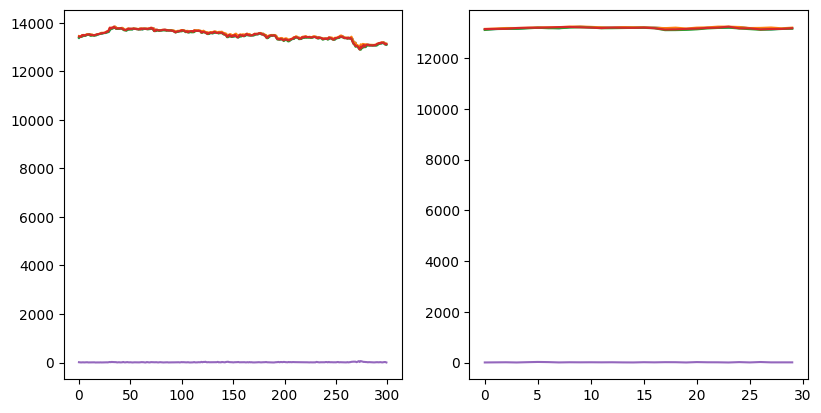

In [17]:
sample = train_dataset[0]

figure, (feature_axe, target_axe) = plot.subplots(1, 2, figsize=(9.6, 4.8))

for name, feature in zip(
    sample.features.schema.names, sample.features.itercolumns(), strict=False
):
    feature_axe.plot(feature.to_numpy(), label=name)

for name, target in zip(
    sample.targets.schema.names, sample.targets.itercolumns(), strict=False
):
    target_axe.plot(target.to_numpy(), label=name)

figure.subplots_adjust(wspace=0.2)

In [18]:
train_dataloader = DataLoader(
    train_dataset,
    BATCH_SIZE,
    collate_fn=ArrowTimeSeriesBatch.from_samples,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
validation_dataloader = DataLoader(
    validation_dataset,
    BATCH_SIZE,
    collate_fn=ArrowTimeSeriesBatch.from_samples,
    pin_memory=True,
    drop_last=True,
)
test_dataloader = DataLoader(
    test_dataset,
    BATCH_SIZE,
    collate_fn=ArrowTimeSeriesBatch.from_samples,
    pin_memory=True,
    drop_last=True,
)

## Utility Functions

In [19]:
loss_function = MSELoss(reduction="mean")

In [20]:
def train_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_function: Callable[[Tensor, Tensor], Tensor],
    optimizer: Optimizer,
) -> tuple[float, int]:
    model.train()

    summary_loss = 0
    batch_count = 0

    with Progress(transient=True) as progress:
        tracker = progress.add_task("Training Epoch", total=len(dataloader))

        batch: ArrowTimeSeriesBatch
        for batch in dataloader:
            features = batch.features.to(device, torch.float32)
            targets = batch.targets.to(device, torch.float32)

            prediction = model(features)
            loss = loss_function(prediction, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            summary_loss += loss.item()
            batch_count += 1

            progress.advance(tracker)

    return summary_loss, batch_count

In [21]:
def evaluate(
    dataloader: DataLoader,
    model: Module,
    loss_function: Callable[[Tensor, Tensor], Tensor],
) -> tuple[float, int]:
    model.eval()

    summary_loss = 0
    batch_count = 0

    with torch.no_grad(), Progress(transient=True) as progress:
        tracker = progress.add_task("Evaluating", total=len(dataloader))

        batch: ArrowTimeSeriesBatch
        for batch in dataloader:
            features = batch.features.to(device, torch.float32)
            targets = batch.targets.to(device, torch.float32)

            prediction = model(features)
            loss = loss_function(prediction, targets)

            summary_loss += loss.item()
            batch_count += 1

            progress.advance(tracker)

    return summary_loss, batch_count

In [90]:
def plot_predictions(
    batch: ArrowTimeSeriesBatch, prediction_batch: Tensor, count: int
) -> None:
    feature_batch = random_batch.features[:count]
    target_batch = random_batch.targets[:count]
    prediction_batch = prediction_batch[:count]

    for features, targets, predictions in zip(
        feature_batch, target_batch, prediction_batch, strict=False
    ):
        figure, (open_axe, volume_axe) = plot.subplots(1, 2, figsize=(12.8, 4.8))

        open_feature = features[:, open_index]
        open_target = targets[:, open_index]
        open_prediction = predictions[:, open_index]

        open_axe.plot(
            range(FEATURE_WINDOW + TARGET_WINDOW),
            torch.cat((open_feature, open_target)),
        )

        open_axe.plot(
            range(FEATURE_WINDOW, FEATURE_WINDOW + TARGET_WINDOW),
            open_prediction,
            linestyle="dashed",
        )

        volume_feature = features[:, volume_index]
        volume_target = targets[:, volume_index]
        volume_prediction = predictions[:, volume_index]

        volume_axe.plot(
            range(FEATURE_WINDOW + TARGET_WINDOW),
            torch.cat((volume_feature, volume_target)),
        )
        volume_axe.plot(
            range(FEATURE_WINDOW, FEATURE_WINDOW + TARGET_WINDOW),
            volume_prediction,
            linestyle="dashed",
        )

        plot.show()

## `NLinear` with Unified Weights

### Initialization

In [23]:
unified_model = NLinearUnified(FEATURE_WINDOW, TARGET_WINDOW).to(device)
optimizer = Adam(unified_model.parameters())

### Training

In [35]:
for epoch in range(EPOCHS):
    pprint(Rule(f"Epoch {epoch}", align="left"))
    train_summary_loss, train_batch_count = train_epoch(
        train_dataloader, unified_model, loss_function, optimizer
    )
    eval_summary_loss, eval_batch_count = evaluate(
        validation_dataloader, unified_model, loss_function
    )

    pprint(
        f"Mean train score: {train_summary_loss / train_batch_count:>7f}, on {train_batch_count} batches."
    )
    pprint(
        f"Mean eval score: {eval_summary_loss / eval_batch_count:>7f}, on {eval_batch_count} batches."
    )

Epoch 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 15896.793060, on 470 batches.

Mean eval score: 66039.632280, on 22 batches.

Epoch 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14942.133339, on 470 batches.

Mean eval score: 66717.464311, on 22 batches.

Epoch 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 15058.033354, on 470 batches.

Mean eval score: 67037.916282, on 22 batches.

Epoch 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14755.899039, on 470 batches.

Mean eval score: 66215.392401, on 22 batches.

Epoch 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14928.150856, on 470 batches.

Mean eval score: 65478.089311, on 22 batches.

Epoch 5 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14930.895641, on 470 batches.

Mean eval score: 66994.993430, on 22 batches.

Epoch 6 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 15083.831859, on 470 batches.

Mean eval score: 68822.829190, on 22 batches.

Epoch 7 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14770.581100, on 470 batches.

Mean eval score: 67851.417702, on 22 batches.

Epoch 8 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14901.212021, on 470 batches.

Mean eval score: 65277.709517, on 22 batches.

Epoch 9 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14697.266447, on 470 batches.

Mean eval score: 80406.704457, on 22 batches.

In [36]:
torch.save(unified_model.state_dict(), Path("../models/nlinear-unified.pth"))

### Results Visualization

In [24]:
unified_model.load_state_dict(torch.load(Path("../models/nlinear-unified.pth")))

<All keys matched successfully>

In [26]:
random_batch = next(iter(test_dataloader))

unified_model.eval()
with torch.no_grad():
    prediction_batch = unified_model(random_batch.features.to(device, torch.float32))

pprint(f"Predictions shape: {prediction_batch.shape}")

Predictions shape: torch.Size([256, 30, 5])

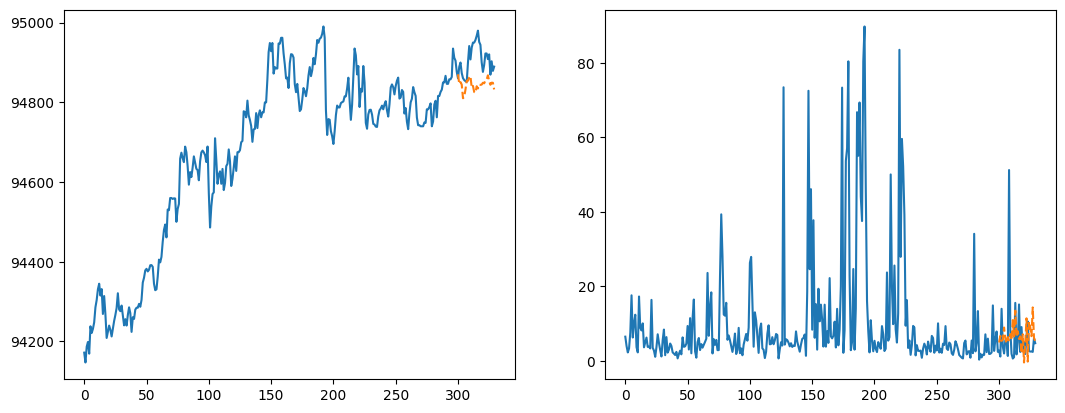

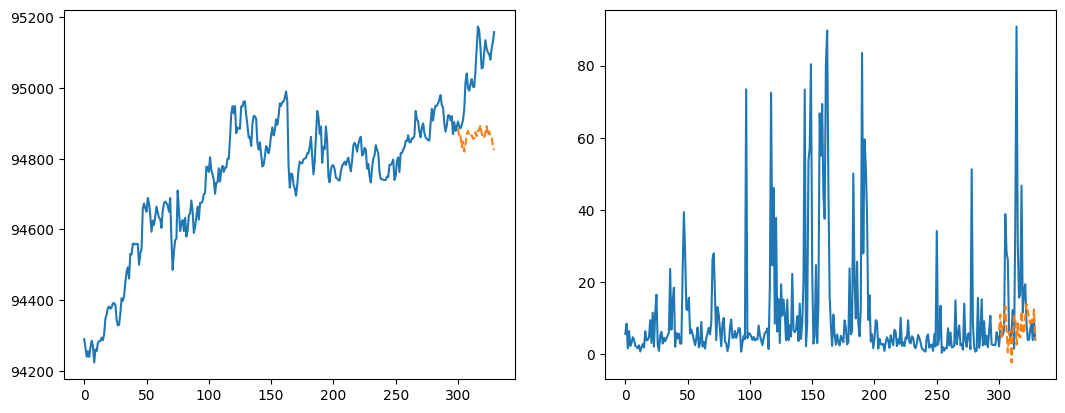

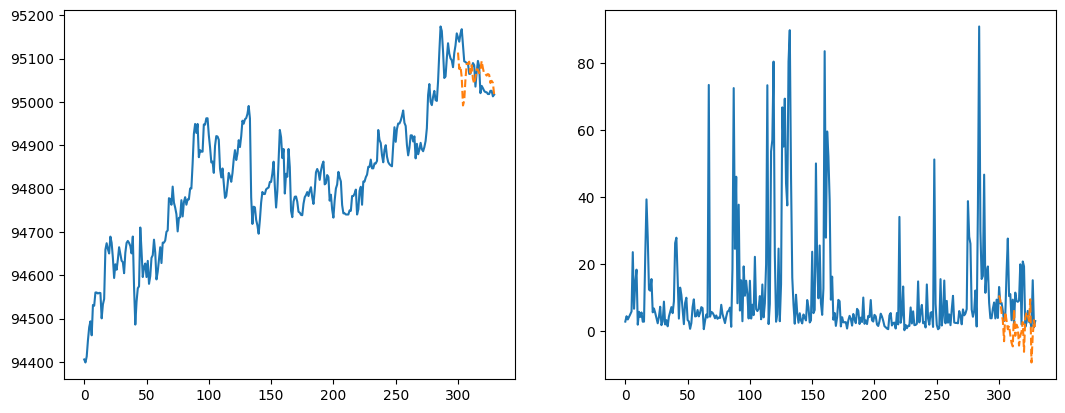

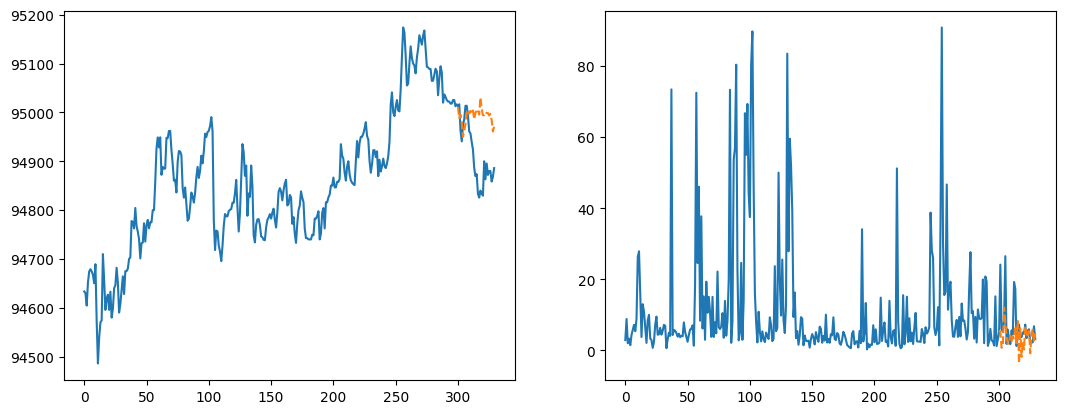

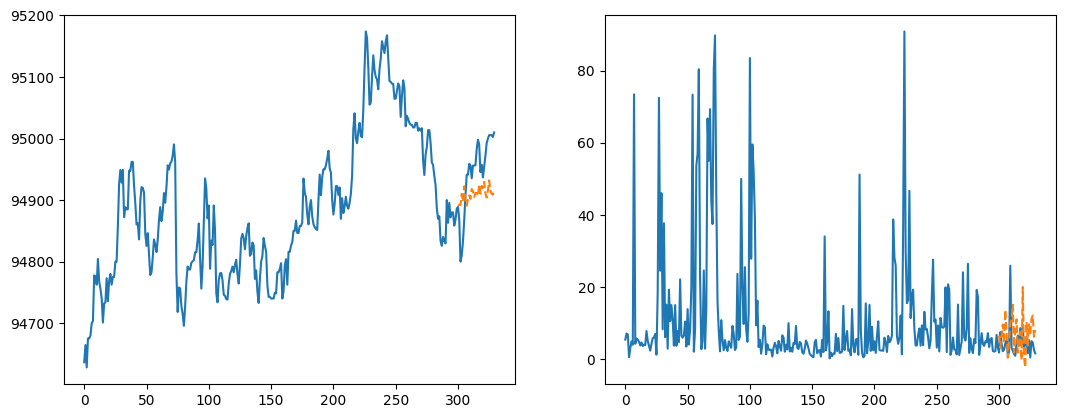

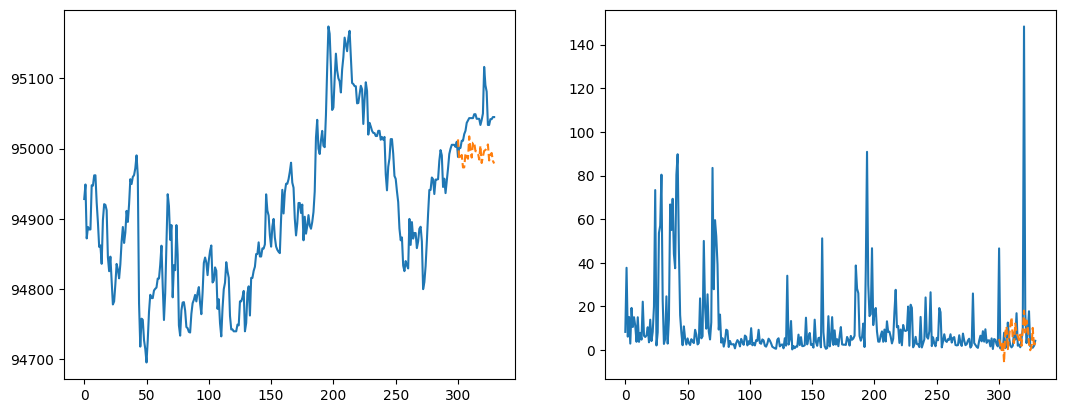

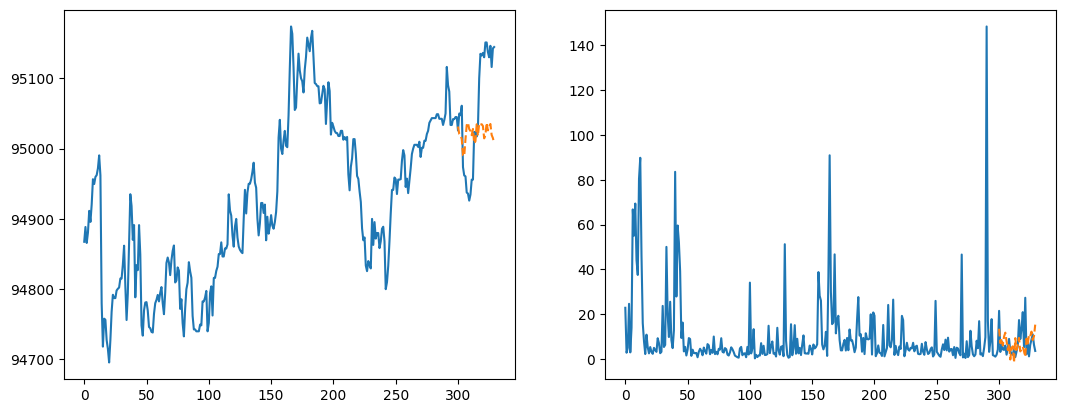

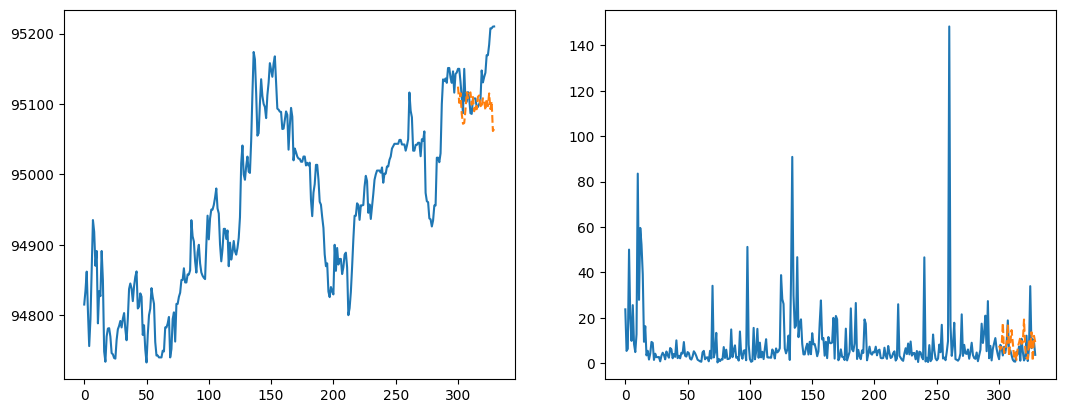

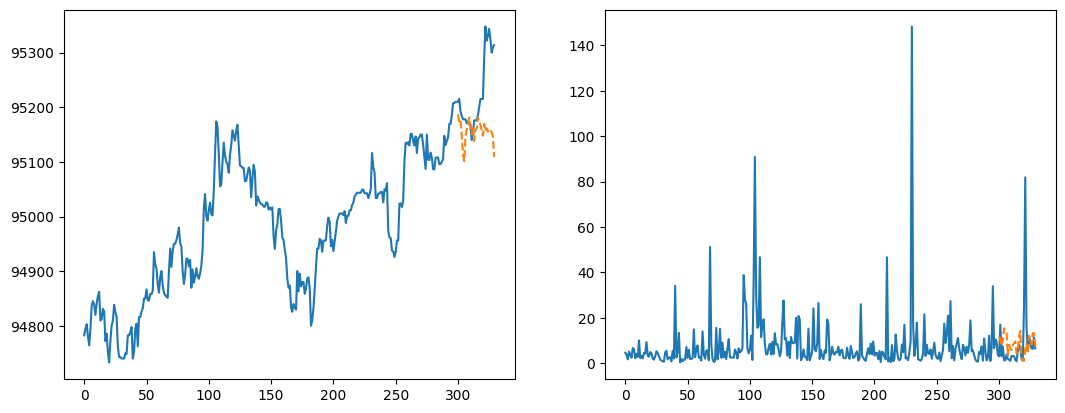

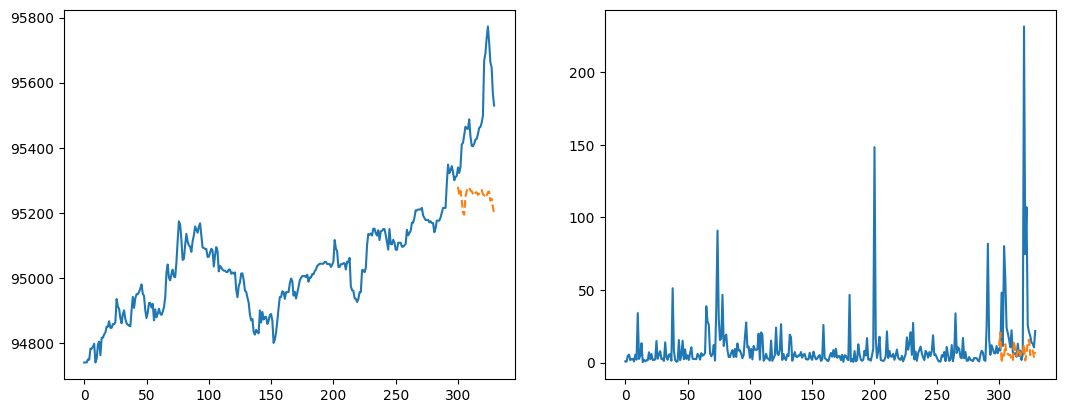

In [27]:
plot_predictions(random_batch, prediction_batch, 10)

## `NLinear` with Individual Weights

### Initialization

In [28]:
assert len(feature_columns) == len(target_columns)

individual_model = NLinearIndividual(
    FEATURE_WINDOW, TARGET_WINDOW, len(target_columns)
).to(device)

optimizer = Adam(individual_model.parameters())

### Training

In [29]:
for epoch in range(EPOCHS):
    pprint(Rule(f"Epoch {epoch}", align="left"))
    train_summary_loss, train_batch_count = train_epoch(
        train_dataloader, individual_model, loss_function, optimizer
    )
    eval_summary_loss, eval_batch_count = evaluate(
        validation_dataloader, individual_model, loss_function
    )

    pprint(
        f"Mean train score: {train_summary_loss / train_batch_count:>7f}, on {train_batch_count} batches."
    )
    pprint(
        f"Mean eval score: {eval_summary_loss / eval_batch_count:>7f}, on {eval_batch_count} batches."
    )

Epoch 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 15474.635153, on 470 batches.

Mean eval score: 71160.394886, on 22 batches.

Epoch 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14744.660716, on 470 batches.

Mean eval score: 72874.942649, on 22 batches.

Epoch 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14569.367833, on 470 batches.

Mean eval score: 76139.121626, on 22 batches.

Epoch 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14646.951226, on 470 batches.

Mean eval score: 68575.552290, on 22 batches.

Epoch 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14489.217585, on 470 batches.

Mean eval score: 65888.020419, on 22 batches.

Epoch 5 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14326.133591, on 470 batches.

Mean eval score: 66214.906250, on 22 batches.

Epoch 6 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14389.440075, on 470 batches.

Mean eval score: 67680.579102, on 22 batches.

Epoch 7 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14385.807063, on 470 batches.

Mean eval score: 66795.857244, on 22 batches.

Epoch 8 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14521.677283, on 470 batches.

Mean eval score: 66778.199574, on 22 batches.

Epoch 9 ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

Output()

Mean train score: 14445.574577, on 470 batches.

Mean eval score: 66206.473278, on 22 batches.

In [30]:
torch.save(individual_model.state_dict(), Path("../models/nlinear-individual.pth"))

### Results Visualization

In [31]:
individual_model.load_state_dict(torch.load(Path("../models/nlinear-individual.pth")))

<All keys matched successfully>

In [33]:
random_batch = next(iter(test_dataloader))

individual_model.eval()
with torch.no_grad():
    prediction_batch = individual_model(random_batch.features.to(device, torch.float32))

pprint(f"Predictions shape: {prediction_batch.shape}")

Predictions shape: torch.Size([256, 30, 5])

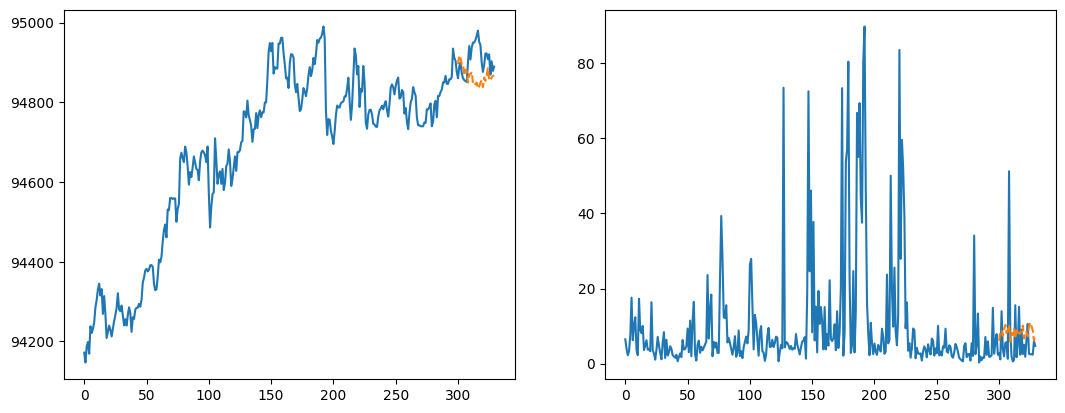

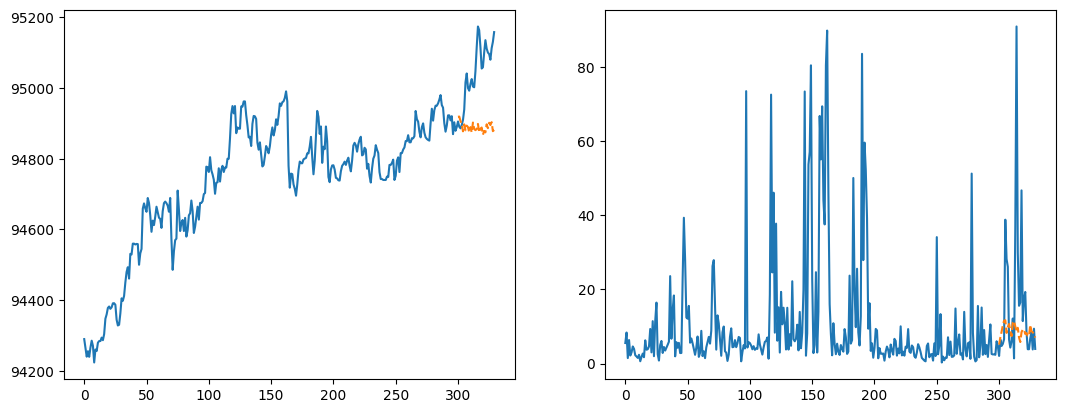

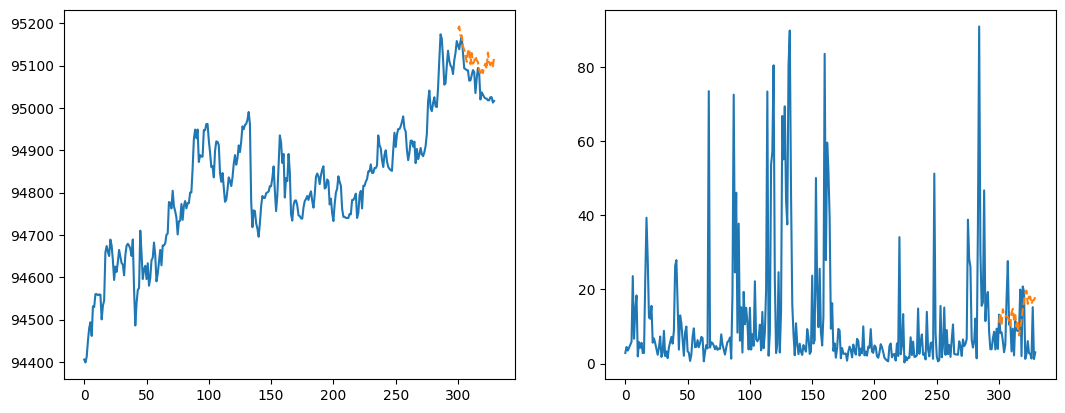

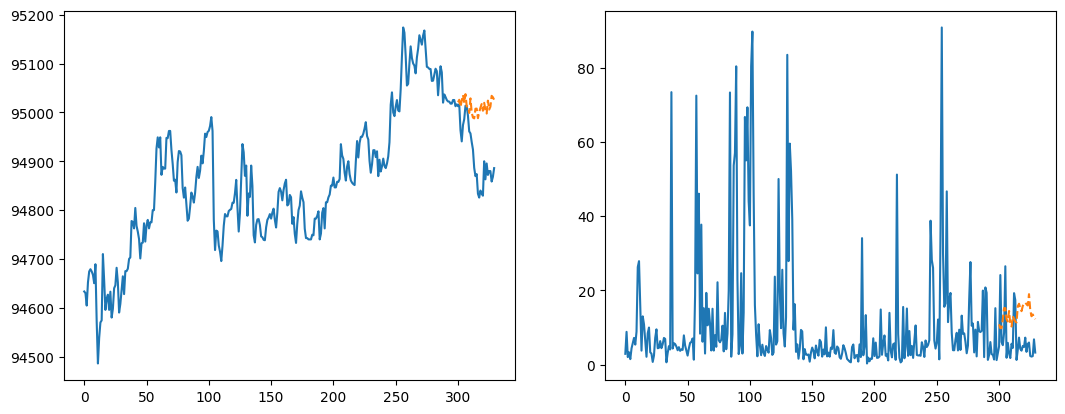

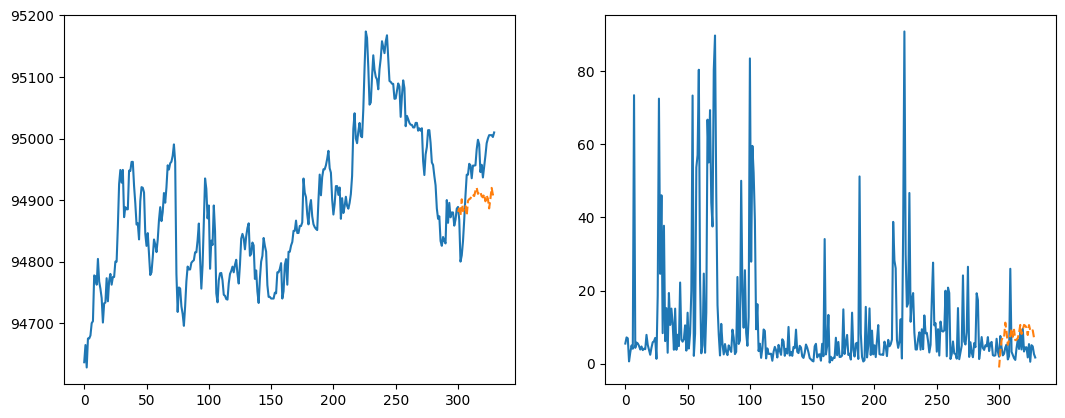

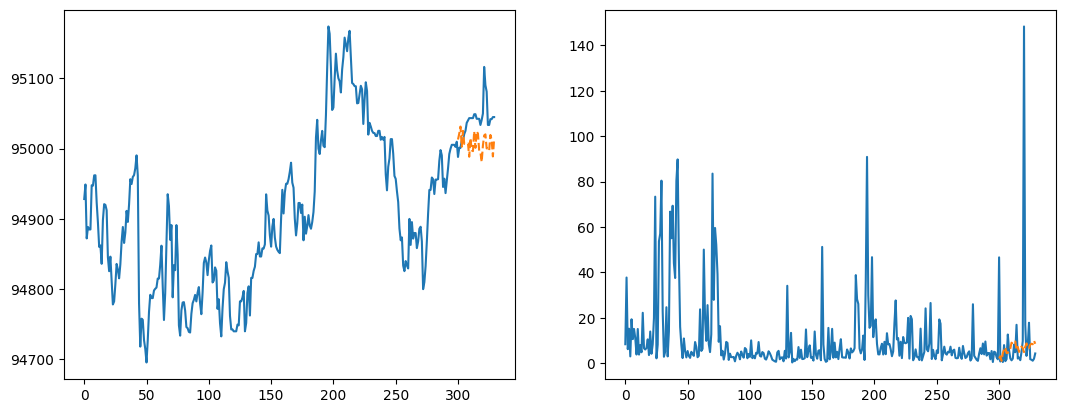

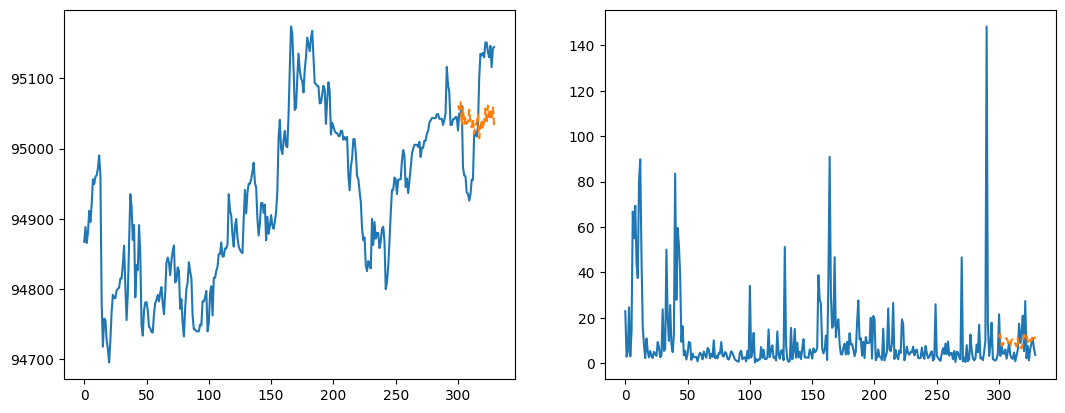

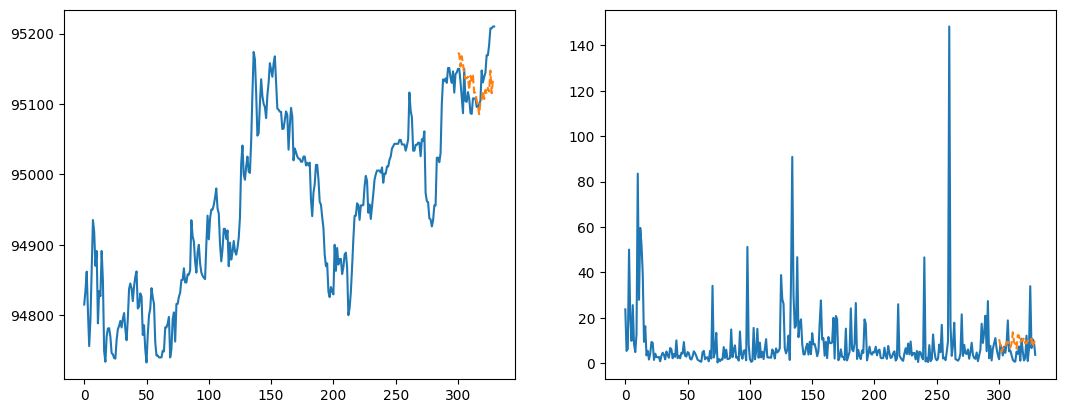

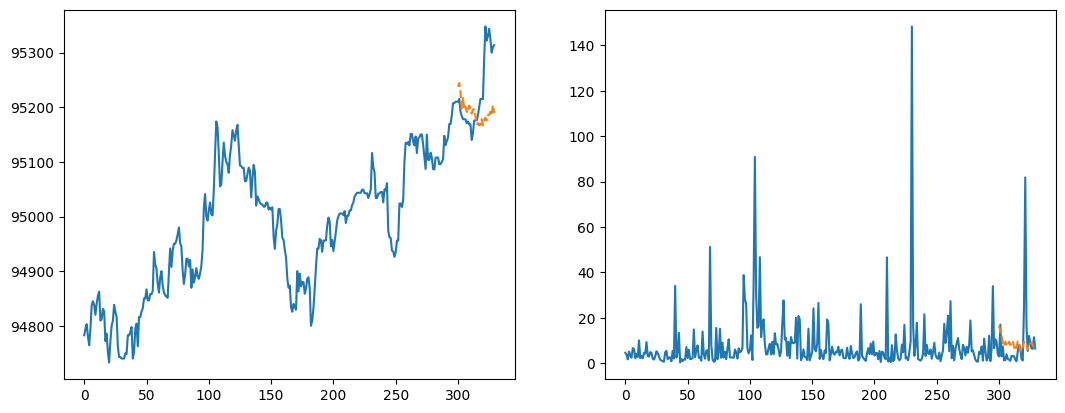

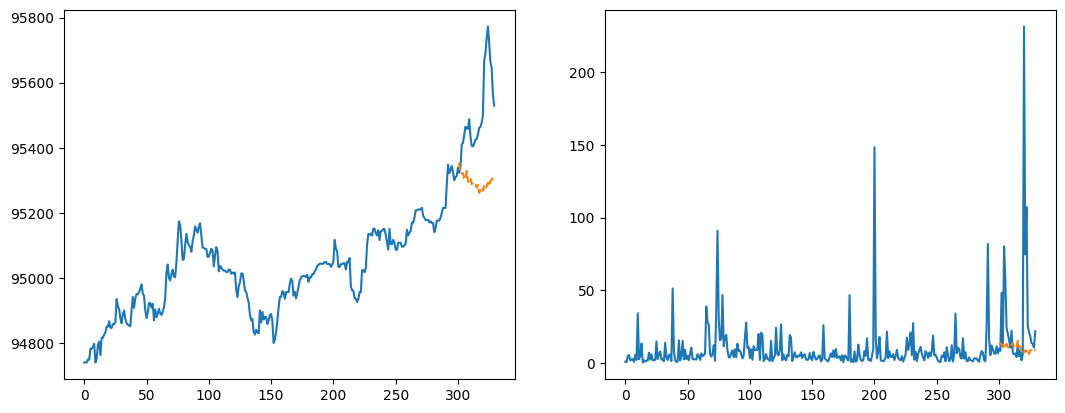

In [34]:
plot_predictions(random_batch, prediction_batch, 10)

## Comparison With Last Element Prediction

### Initialization

In [40]:
class LastElementRepeater(Module):
    def __init__(self, forecast_window: int) -> None:
        super().__init__()

        self._forecast_window = forecast_window

    # x: [Batch; Length; Channels]
    def forward(self, x: Tensor) -> Tensor:
        return x[:, -1:, :].repeat(1, self._forecast_window, 1)


repeater_model = LastElementRepeater(TARGET_WINDOW)

### Results Visualization

In [42]:
random_batch = next(iter(test_dataloader))

repeater_model.eval()
with torch.no_grad():
    prediction_batch = repeater_model(random_batch.features.to(device, torch.float32))

pprint(f"Predictions shape: {prediction_batch.shape}")

Predictions shape: torch.Size([256, 30, 5])

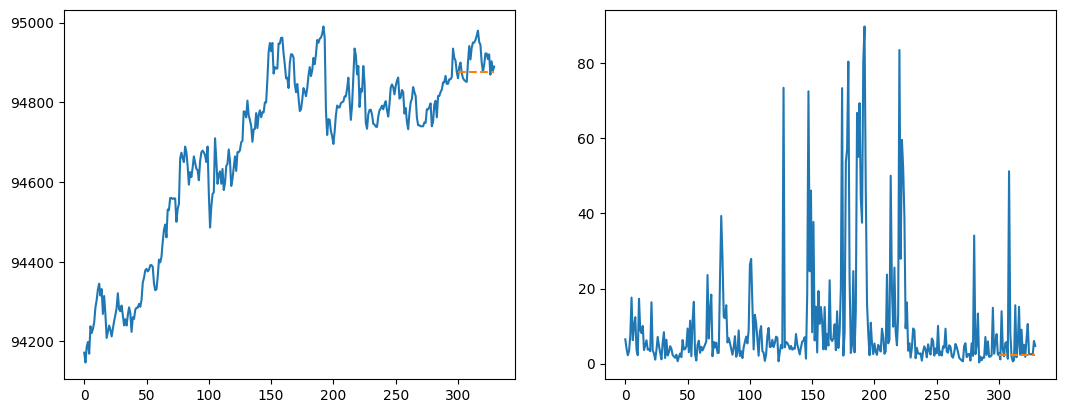

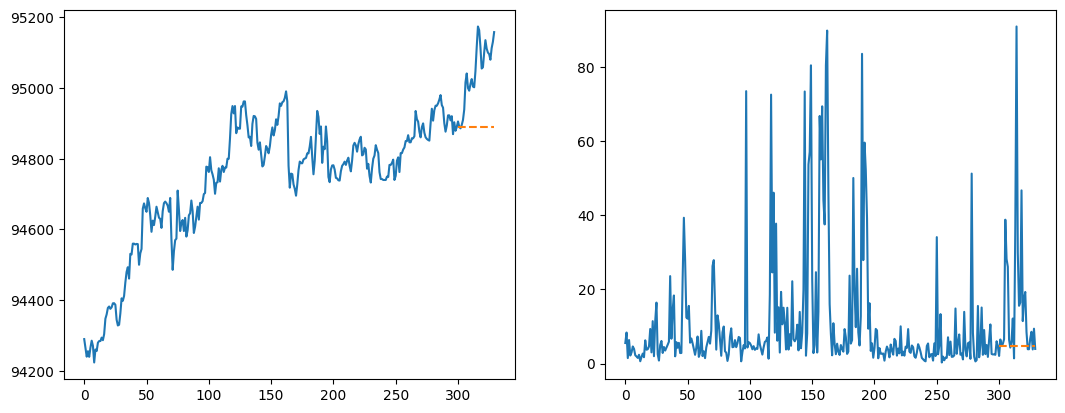

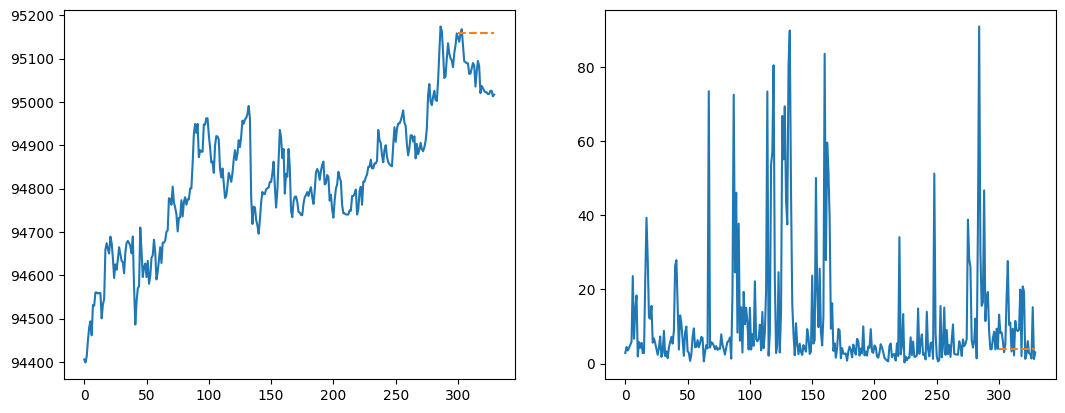

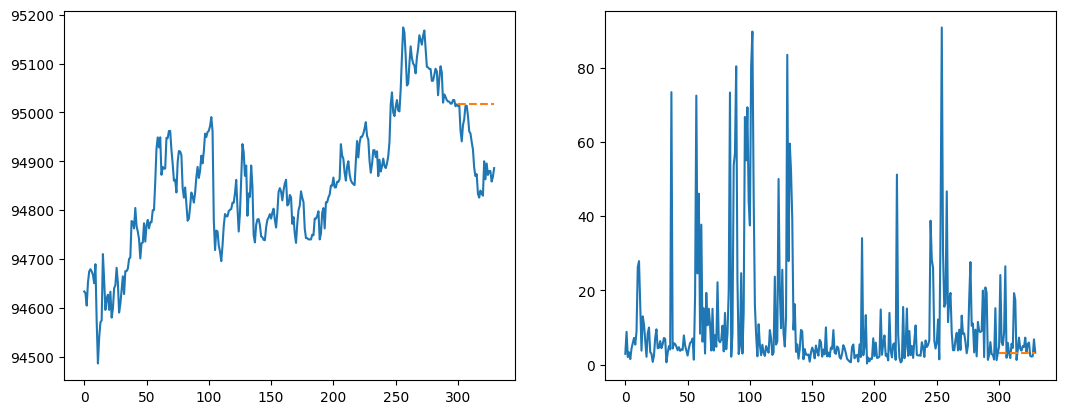

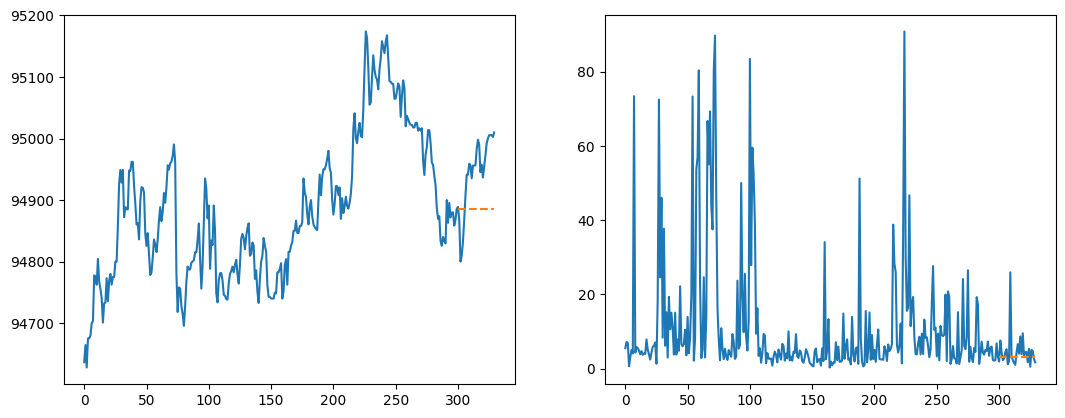

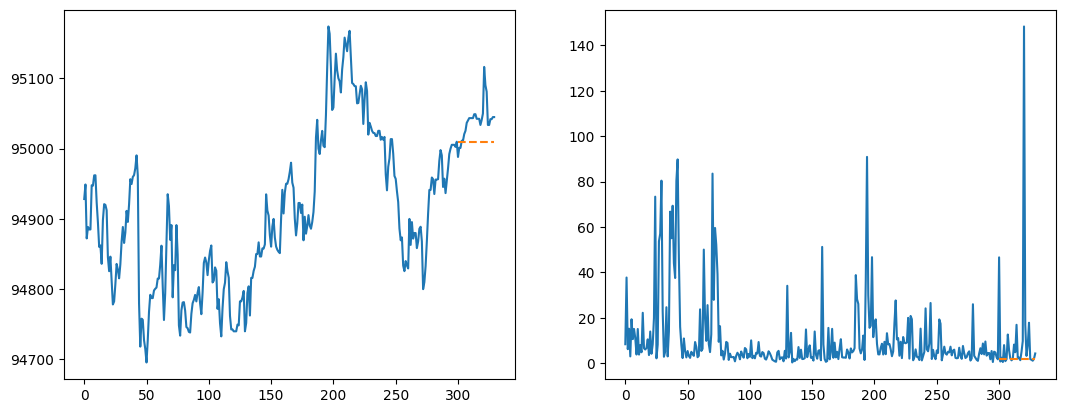

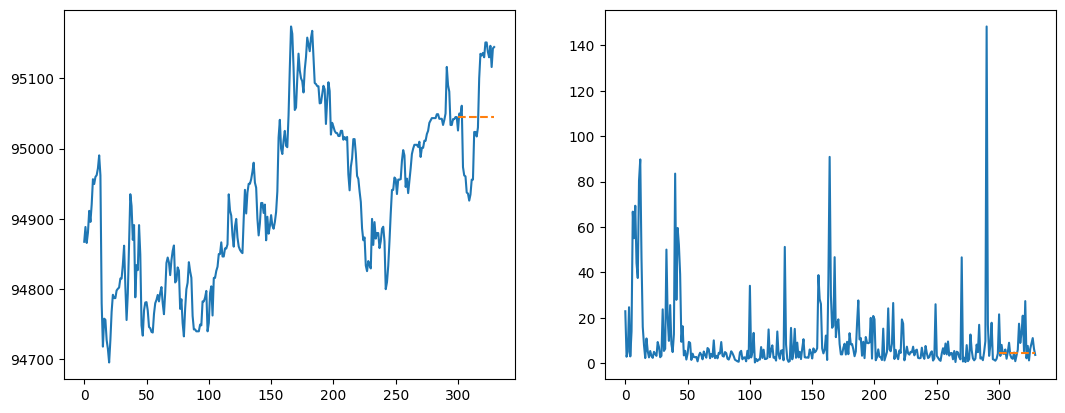

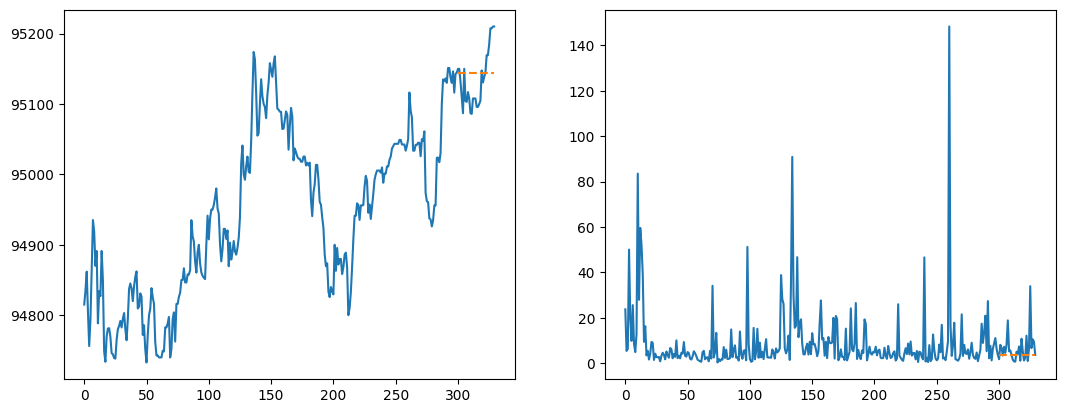

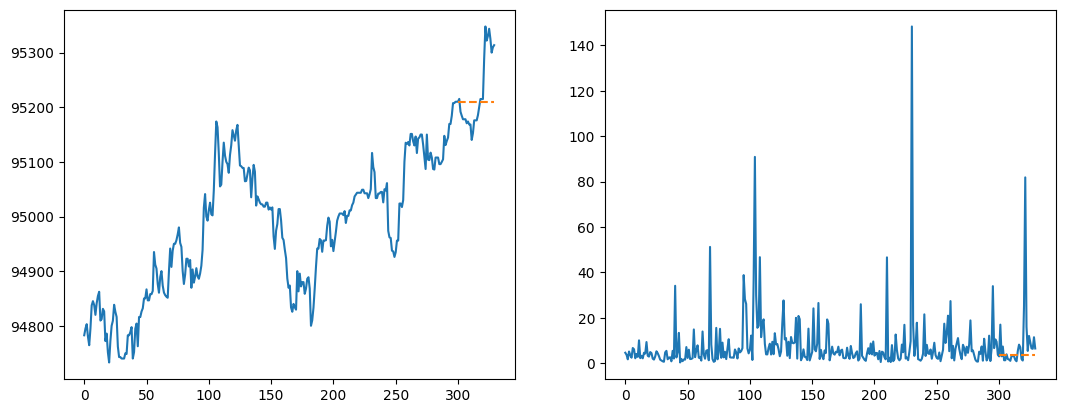

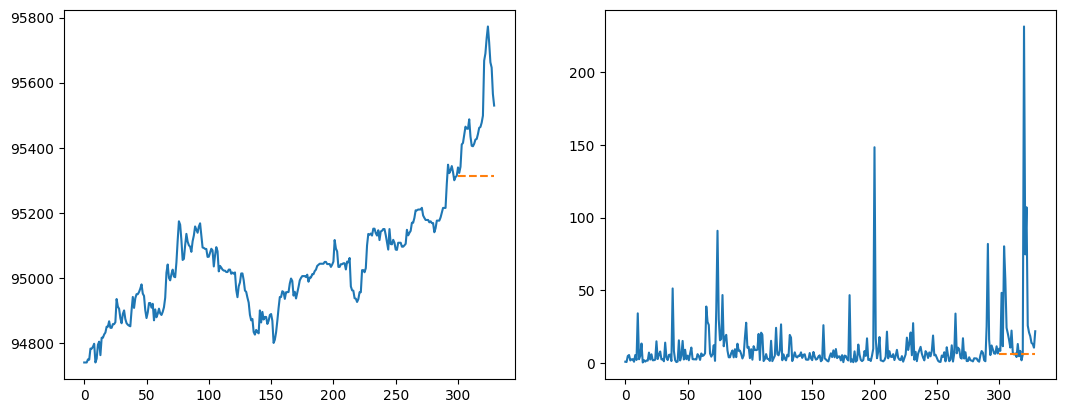

In [43]:
plot_predictions(random_batch, prediction_batch, 10)

### MAE Loss Comparison

In [66]:
mae_loss = L1Loss(reduction="mean")

In [67]:
for model, model_name in zip(
    [repeater_model, unified_model, individual_model],
    ["Repeater", "NLinear Unified", "NLinear Individual"],
    strict=False,
):
    pprint(Rule(f"Model {model_name}", align="left"))

    for dataloader, data_name in zip(
        [train_dataloader, validation_dataloader, test_dataloader],
        ["Train", "Validation", "Test"],
        strict=False,
    ):
        summary_loss, batch_count = evaluate(dataloader, model, mae_loss)
        pprint(
            f"{data_name}: {summary_loss / batch_count:>7f}, on {batch_count} batches."
        )

Model Repeater ────────────────────────────────────────────────────────────────────────────────────────────────────

Output()

/home/zitrasa/baikal/baikal-ml/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 
'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

Train: 55.077793, on 470 batches.

Output()

Validation: 141.697154, on 22 batches.

Output()

Test: 109.427489, on 23 batches.

Model NLinear Unified ─────────────────────────────────────────────────────────────────────────────────────────────

Output()

Train: 60.330548, on 470 batches.

Output()

Validation: 158.597478, on 22 batches.

Output()

Test: 123.219576, on 23 batches.

Model NLinear Individual ──────────────────────────────────────────────────────────────────────────────────────────

Output()

Train: 54.320311, on 470 batches.

Output()

Validation: 143.190038, on 22 batches.

Output()

Test: 110.955128, on 23 batches.

### Utility Function

In [80]:
# Output: Sum [0..N] of loss, N
# N: Total sample count across all batches
def evaluate_custom_loss(
    dataloader: DataLoader,
    model: Module,
    loss_function: Callable[[Tensor, Tensor], Tensor],
) -> tuple[Tensor, int]:
    model.eval()

    summary_loss: Tensor | None = None
    sample_count: int = 0

    with torch.no_grad(), Progress(transient=True) as progress:
        tracker = progress.add_task("Evaluating", total=len(dataloader))

        batch: ArrowTimeSeriesBatch
        for batch in dataloader:
            features = batch.features.to(device, torch.float32)
            targets = batch.targets.to(device, torch.float32)

            prediction = model(features)
            loss = loss_function(prediction, targets)

            if summary_loss is None:
                summary_loss = loss
            else:
                summary_loss += loss

            sample_count += targets.size(0)
            progress.advance(tracker)

    return summary_loss, sample_count

### Per-Position Absolute Error Comparison

In [136]:
def count_mae_per_position(prediction: Tensor, targets: Tensor) -> Tensor:
    return torch.sum(torch.abs(prediction - targets), dim=(0, 2))

Output()

/home/zitrasa/baikal/baikal-ml/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 
'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

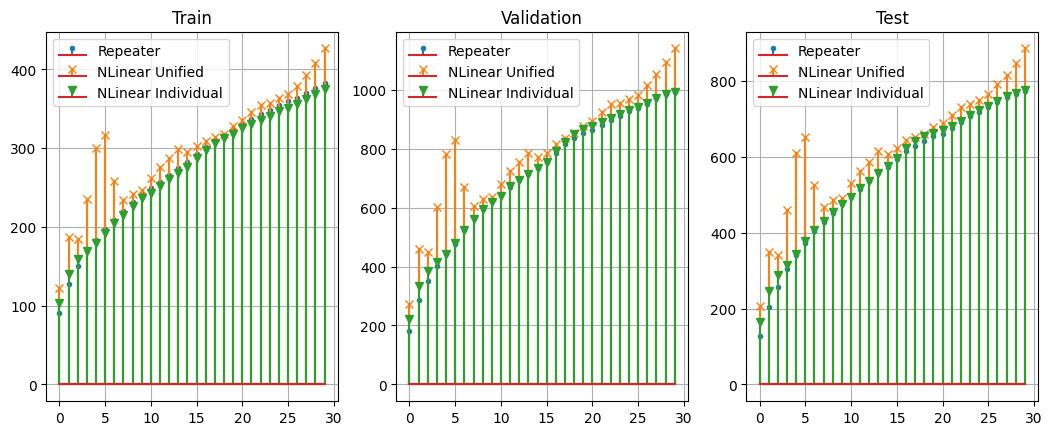

In [88]:
figure, axes = plot.subplots(1, 3, figsize=(12.8, 4.8))

for dataloader, data_name, axe in zip(
    [train_dataloader, validation_dataloader, test_dataloader],
    ["Train", "Validation", "Test"],
    axes,
    strict=False,
):
    axe.set_title(data_name)

    for model, model_name, index, marker in zip(
        [repeater_model, unified_model, individual_model],
        ["Repeater", "NLinear Unified", "NLinear Individual"],
        [0, 1, 2],
        [".", "x", "v"],
        strict=False,
    ):
        summary_loss, sample_count = evaluate_custom_loss(
            dataloader, model, count_mae_per_position
        )
        axe.stem(
            summary_loss / sample_count,
            label=model_name,
            linefmt=f"C{index}-",
            markerfmt=f"C{index}{marker}",
        )

    axe.grid()
    axe.legend()

### Counting Losses on OHLC Invariant Violations (H < Max & L > Min)

In [130]:
# Inputs: [Batch; Target-Length; Channels]
# Output: [Target-Length]
def count_invariant_violation(prediction: Tensor, targets: Tensor) -> Tensor:
    filtered_targets = targets[:, :, [open_index, high_index, low_index, close_index]]

    real_high = torch.max(filtered_targets, dim=2).values
    high_diff = real_high - targets[:, :, high_index]
    high_loss = torch.where(high_diff > 0, high_diff, 0)

    real_low = torch.min(filtered_targets, dim=2).values
    low_diff = targets[:, :, low_index] - real_low
    low_loss = torch.where(low_diff > 0, low_diff, 0)

    return torch.sum(high_loss + low_loss, dim=0)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

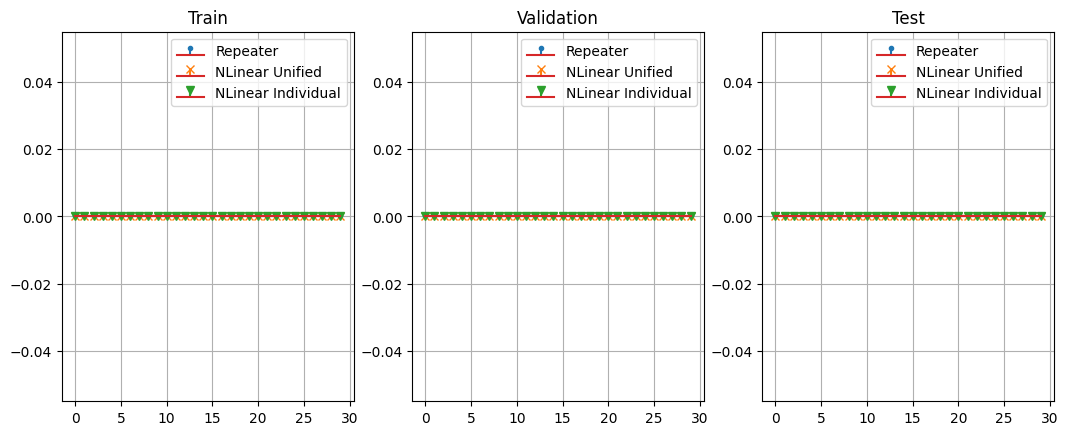

In [133]:
figure, axes = plot.subplots(1, 3, figsize=(12.8, 4.8))

for dataloader, data_name, axe in zip(
    [train_dataloader, validation_dataloader, test_dataloader],
    ["Train", "Validation", "Test"],
    axes,
    strict=False,
):
    axe.set_title(data_name)

    for model, model_name, index, marker in zip(
        [repeater_model, unified_model, individual_model],
        ["Repeater", "NLinear Unified", "NLinear Individual"],
        [0, 1, 2],
        [".", "x", "v"],
        strict=False,
    ):
        summary_loss, sample_count = evaluate_custom_loss(
            dataloader, model, count_invariant_violation
        )
        axe.stem(
            summary_loss / sample_count,
            label=model_name,
            linefmt=f"C{index}-",
            markerfmt=f"C{index}{marker}",
        )

    axe.grid()
    axe.legend()